In [49]:
import torch
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi


CUDA available: True
Tue Dec  2 11:23:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

In [50]:
import os

base_path = "/kaggle/input/rsna-bone-age"
print("Files in dataset folder:", os.listdir(base_path))

# Check contents of the training folder
train_folder = os.path.join(base_path, "boneage-training-dataset")
print("Number of training subfolders/files:", len(os.listdir(train_folder)))
print("Sample files:", os.listdir(train_folder)[:5])


Files in dataset folder: ['boneage-training-dataset.csv', 'boneage-training-dataset', 'boneage-test-dataset', 'boneage-test-dataset.csv']
Number of training subfolders/files: 1
Sample files: ['boneage-training-dataset']


In [51]:
import pandas as pd

train_csv = os.path.join(base_path, 'boneage-training-dataset.csv')
df = pd.read_csv(train_csv)
print("CSV loaded successfully")
print(df.head())
print("Columns:", df.columns)


CSV loaded successfully
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False
Columns: Index(['id', 'boneage', 'male'], dtype='object')


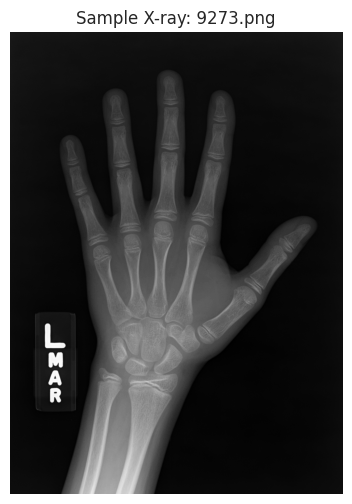

In [52]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the inner folder that contains images
inner_train_folder = os.path.join(train_folder, "boneage-training-dataset")

# List files in that folder
sample_img_name = os.listdir(inner_train_folder)[0]
sample_img_path = os.path.join(inner_train_folder, sample_img_name)

# Open and display the image
img = Image.open(sample_img_path)
plt.imshow(img, cmap='gray')
plt.title(f"Sample X-ray: {sample_img_name}")
plt.axis('off')
plt.show()


In [53]:
# Core data manipulation and numerical computing
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Image processing
from PIL import Image
import cv2

# Utility libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [54]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define file paths
IMAGE_DIR = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'
CSV_PATH = "/kaggle/input/rsna-bone-age/boneage-training-dataset.csv"

print("=" * 80)
print("RSNA Bone Age Prediction - Setup Complete")
print("=" * 80)
print(f"Image Directory: {IMAGE_DIR}")
print(f"CSV Path: {CSV_PATH}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print("=" * 80)


RSNA Bone Age Prediction - Setup Complete
Image Directory: /kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/
CSV Path: /kaggle/input/rsna-bone-age/boneage-training-dataset.csv
PyTorch Version: 2.6.0+cu124
CUDA Available: True
GPU Device: Tesla P100-PCIE-16GB


In [55]:
import os

print("CSV exists:", os.path.exists(CSV_PATH))
print("Number of images in folder:", len(os.listdir(IMAGE_DIR)))
print("Sample images:", os.listdir(IMAGE_DIR)[:5])


CSV exists: True
Number of images in folder: 12611
Sample images: ['9273.png', '14127.png', '9292.png', '11396.png', '14260.png']


In [56]:
import os
import pandas as pd

print("\n[STEP 1] Loading CSV metadata...")

# Load the training metadata
df = pd.read_csv(CSV_PATH)

# Map full image paths
df['path'] = df['id'].astype(str).apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.png"))

# Verify files exist
df['file_exists'] = df['path'].apply(os.path.exists)
missing_files = (~df['file_exists']).sum()

print(f"Total records loaded: {len(df)}")
print(f"Missing image files: {missing_files}")
if missing_files > 0:
    print("WARNING: Some image files are missing!")
    df = df[df['file_exists']].copy()
    print(f"Proceeding with {len(df)} valid records")

# Drop temporary column
df = df.drop('file_exists', axis=1)

print("✓ Data loading complete\n")
print(df.head())



[STEP 1] Loading CSV metadata...
Total records loaded: 12611
Missing image files: 0
✓ Data loading complete

     id  boneage   male                                               path
0  1377      180  False  /kaggle/input/rsna-bone-age/boneage-training-d...
1  1378       12  False  /kaggle/input/rsna-bone-age/boneage-training-d...
2  1379       94  False  /kaggle/input/rsna-bone-age/boneage-training-d...
3  1380      120   True  /kaggle/input/rsna-bone-age/boneage-training-d...
4  1381       82  False  /kaggle/input/rsna-bone-age/boneage-training-d...


In [57]:
print("[STEP 2] Feature Engineering...")

# 1. Convert bone age from months to years
df['bone_age_years'] = df['boneage'] / 12.0

# 2. Encode sex as binary (M=1, F=0)
df['sex_encoded'] = df['male'].astype(int)

# Display the transformations
print("\nOriginal columns:")
print(df[['id', 'boneage', 'male']].head(3))
print("\nNew engineered features:")
print(df[['id', 'bone_age_years', 'sex_encoded']].head(3))

print("✓ Feature engineering complete\n")


[STEP 2] Feature Engineering...

Original columns:
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False

New engineered features:
     id  bone_age_years  sex_encoded
0  1377       15.000000            0
1  1378        1.000000            0
2  1379        7.833333            0
✓ Feature engineering complete



In [58]:
print("[STEP 3] Exploratory Data Analysis")
print("=" * 80)

# Summary Statistics
print("\n📊 Dataset Information:")
print(df.info())

print("\n📊 Statistical Summary:")
print(df[['boneage', 'bone_age_years', 'sex_encoded']].describe())

print("\n📊 First few records:")
print(df.head())

print("\n📊 Sex Distribution:")
print(df['male'].value_counts())

print("\n📊 Bone Age Statistics (in years):")
print(f"Mean: {df['bone_age_years'].mean():.2f} years")
print(f"Median: {df['bone_age_years'].median():.2f} years")
print(f"Min: {df['bone_age_years'].min():.2f} years")
print(f"Max: {df['bone_age_years'].max():.2f} years")
print(f"Std Dev: {df['bone_age_years'].std():.2f} years")


[STEP 3] Exploratory Data Analysis

📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12611 entries, 0 to 12610
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              12611 non-null  int64  
 1   boneage         12611 non-null  int64  
 2   male            12611 non-null  bool   
 3   path            12611 non-null  object 
 4   bone_age_years  12611 non-null  float64
 5   sex_encoded     12611 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 505.1+ KB
None

📊 Statistical Summary:
            boneage  bone_age_years   sex_encoded
count  12611.000000    12611.000000  12611.000000
mean     127.320752       10.610063      0.541829
std       41.182021        3.431835      0.498267
min        1.000000        0.083333      0.000000
25%       96.000000        8.000000      0.000000
50%      132.000000       11.000000      1.000000
75%      156.000000  


[Creating Visualizations...]


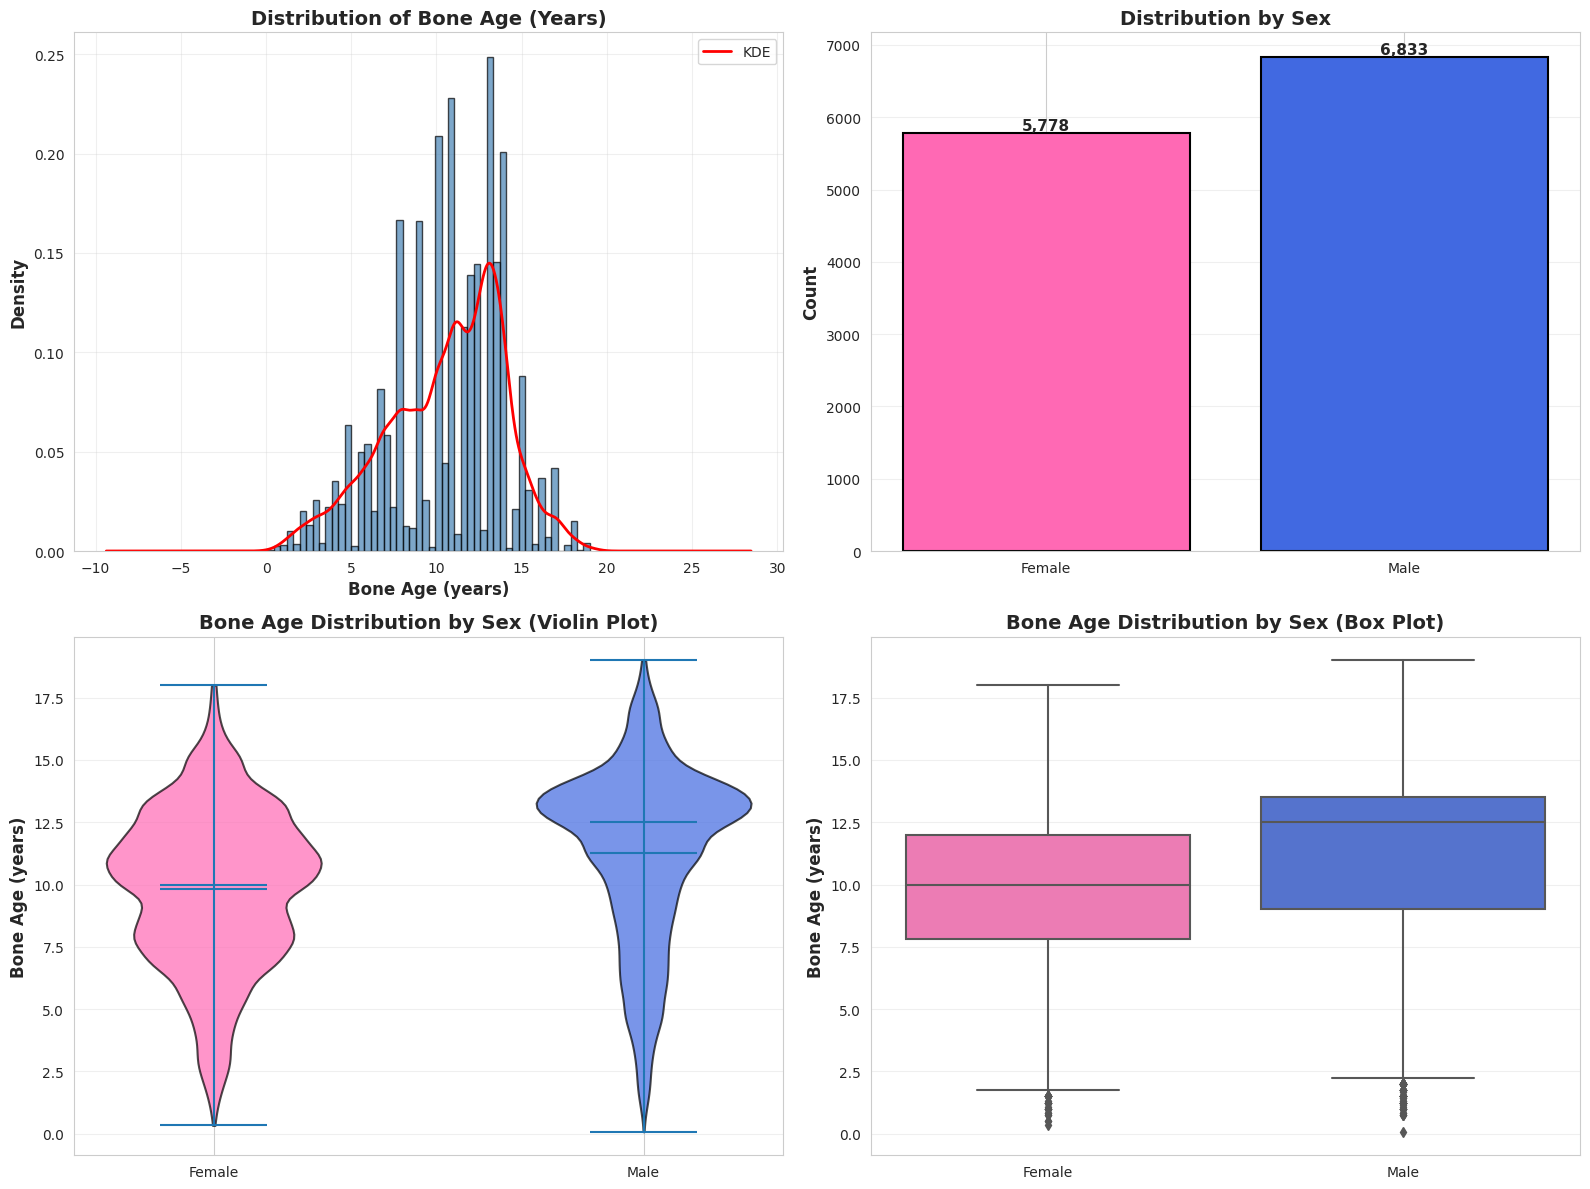


📊 Gender-wise Bone Age Statistics:

Male:
  Count: 6,833
  Mean: 11.28 years
  Median: 12.50 years
  Std Dev: 3.51 years
  Min: 0.08 years
  Max: 19.00 years

Female:
  Count: 5,778
  Mean: 9.82 years
  Median: 10.00 years
  Std Dev: 3.16 years
  Min: 0.33 years
  Max: 18.00 years

📊 T-test for difference in mean bone age between sexes:
  T-statistic: 24.2159
  P-value: 0.0000
  → Statistically significant difference detected (p < 0.05)

✓ EDA Complete - Ready for Model Development


In [59]:
print("\n[Creating Visualizations...]")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Bone Age Distribution with KDE
ax1 = axes[0, 0]
ax1.hist(df['bone_age_years'], bins=50, alpha=0.7, color='steelblue', edgecolor='black', density=True)
df['bone_age_years'].plot(kind='kde', ax=ax1, color='red', linewidth=2, label='KDE')
ax1.set_xlabel('Bone Age (years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Bone Age (Years)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sex Count
ax2 = axes[0, 1]
sex_counts = df['male'].value_counts()
sex_labels = ['Female', 'Male']
colors = ['#FF69B4', '#4169E1']
bars = ax2.bar(sex_labels, [sex_counts[False], sex_counts[True]], color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Distribution by Sex', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 3: Violin Plot - Bone Age by Sex
ax3 = axes[1, 0]
violin_data = [df[df['male'] == False]['bone_age_years'].values,
               df[df['male'] == True]['bone_age_years'].values]
parts = ax3.violinplot(violin_data, positions=[0, 1], showmeans=True, showmedians=True)

# Customize violin plot colors
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Female', 'Male'])
ax3.set_ylabel('Bone Age (years)', fontsize=12, fontweight='bold')
ax3.set_title('Bone Age Distribution by Sex (Violin Plot)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Box Plot - Additional comparison
ax4 = axes[1, 1]
box_data = df[['male', 'bone_age_years']].copy()
box_data['Sex'] = box_data['male'].map({True: 'Male', False: 'Female'})
sns.boxplot(data=box_data, x='Sex', y='bone_age_years', palette=colors, ax=ax4)
ax4.set_ylabel('Bone Age (years)', fontsize=12, fontweight='bold')
ax4.set_xlabel('')
ax4.set_title('Bone Age Distribution by Sex (Box Plot)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# ============================================================================
# ADDITIONAL ANALYSIS: Gender-wise Statistics
# ============================================================================

print("\n📊 Gender-wise Bone Age Statistics:")
print("=" * 80)

for sex, label in [(True, 'Male'), (False, 'Female')]:
    sex_data = df[df['male'] == sex]['bone_age_years']
    print(f"\n{label}:")
    print(f"  Count: {len(sex_data):,}")
    print(f"  Mean: {sex_data.mean():.2f} years")
    print(f"  Median: {sex_data.median():.2f} years")
    print(f"  Std Dev: {sex_data.std():.2f} years")
    print(f"  Min: {sex_data.min():.2f} years")
    print(f"  Max: {sex_data.max():.2f} years")

# Statistical test for difference in means
from scipy import stats
male_ages = df[df['male'] == True]['bone_age_years']
female_ages = df[df['male'] == False]['bone_age_years']
t_stat, p_value = stats.ttest_ind(male_ages, female_ages)

print(f"\n📊 T-test for difference in mean bone age between sexes:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value < 0.05:
    print("  → Statistically significant difference detected (p < 0.05)")
else:
    print("  → No significant difference detected (p >= 0.05)")

print("\n" + "=" * 80)
print("✓ EDA Complete - Ready for Model Development")
print("=" * 80)

In [60]:
print("\n📋 PROJECT SETUP SUMMARY")
print("=" * 80)
print(f"Total Images: {len(df):,}")
print(f"Feature Columns: {list(df.columns)}")
print(f"Target Variable (Regression): bone_age_years")
print(f"Age Range: {df['bone_age_years'].min():.1f} - {df['bone_age_years'].max():.1f} years")
print(f"Sex Distribution: {(df['male']==False).sum():,} Female, {(df['male']==True).sum():,} Male")
print("\n✓ All setup steps completed successfully!")
print("✓ Data is ready for train/validation split and model training")
print("=" * 80)


📋 PROJECT SETUP SUMMARY
Total Images: 12,611
Feature Columns: ['id', 'boneage', 'male', 'path', 'bone_age_years', 'sex_encoded']
Target Variable (Regression): bone_age_years
Age Range: 0.1 - 19.0 years
Sex Distribution: 5,778 Female, 6,833 Male

✓ All setup steps completed successfully!
✓ Data is ready for train/validation split and model training


## Data Preprocessing

In [61]:
print("=" * 80)
print("BONE AGE PREDICTION - DATA PREPARATION PIPELINE")
print("=" * 80)

BONE AGE PREDICTION - DATA PREPARATION PIPELINE


In [62]:
print("\n[STEP 1] Performing Stratified Dataset Split...")
print("-" * 80)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Verify required columns exist
required_cols = ['path', 'bone_age_years', 'sex_encoded']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"Total samples in dataset: {len(df):,}")
print(f"Stratification column: sex_encoded")
print(f"Sex distribution in full dataset:")
print(df['sex_encoded'].value_counts().sort_index())

# First split: 70% train, 30% temp (which will be split into val and test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['sex_encoded'],
    random_state=RANDOM_STATE
)

# Second split: Split the 30% temp into 15% val and 15% test (50-50 split of temp)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # 50% of 30% = 15% of total
    stratify=temp_df['sex_encoded'],
    random_state=RANDOM_STATE
)

# Reset indices for clean DataFrames
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Verify split ratios
total_samples = len(df)
train_pct = len(train_df) / total_samples * 100
val_pct = len(val_df) / total_samples * 100
test_pct = len(test_df) / total_samples * 100

print(f"\n✓ Split completed successfully!")
print(f"  Train: {len(train_df):,} samples ({train_pct:.1f}%)")
print(f"  Val:   {len(val_df):,} samples ({val_pct:.1f}%)")
print(f"  Test:  {len(test_df):,} samples ({test_pct:.1f}%)")

# Verify stratification maintained
print(f"\n📊 Stratification Verification (sex_encoded distribution):")
print(f"  Train - Female: {(train_df['sex_encoded']==0).sum():,} ({(train_df['sex_encoded']==0).sum()/len(train_df)*100:.1f}%), "
      f"Male: {(train_df['sex_encoded']==1).sum():,} ({(train_df['sex_encoded']==1).sum()/len(train_df)*100:.1f}%)")
print(f"  Val   - Female: {(val_df['sex_encoded']==0).sum():,} ({(val_df['sex_encoded']==0).sum()/len(val_df)*100:.1f}%), "
      f"Male: {(val_df['sex_encoded']==1).sum():,} ({(val_df['sex_encoded']==1).sum()/len(val_df)*100:.1f}%)")
print(f"  Test  - Female: {(test_df['sex_encoded']==0).sum():,} ({(test_df['sex_encoded']==0).sum()/len(test_df)*100:.1f}%), "
      f"Male: {(test_df['sex_encoded']==1).sum():,} ({(test_df['sex_encoded']==1).sum()/len(test_df)*100:.1f}%)")

# Verify target distribution similarity
print(f"\n📊 Target Distribution (bone_age_years):")
print(f"  Train - Mean: {train_df['bone_age_years'].mean():.2f}, Std: {train_df['bone_age_years'].std():.2f}")
print(f"  Val   - Mean: {val_df['bone_age_years'].mean():.2f}, Std: {val_df['bone_age_years'].std():.2f}")
print(f"  Test  - Mean: {test_df['bone_age_years'].mean():.2f}, Std: {test_df['bone_age_years'].std():.2f}")




[STEP 1] Performing Stratified Dataset Split...
--------------------------------------------------------------------------------
Total samples in dataset: 12,611
Stratification column: sex_encoded
Sex distribution in full dataset:
sex_encoded
0    5778
1    6833
Name: count, dtype: int64

✓ Split completed successfully!
  Train: 8,827 samples (70.0%)
  Val:   1,892 samples (15.0%)
  Test:  1,892 samples (15.0%)

📊 Stratification Verification (sex_encoded distribution):
  Train - Female: 4,044 (45.8%), Male: 4,783 (54.2%)
  Val   - Female: 867 (45.8%), Male: 1,025 (54.2%)
  Test  - Female: 867 (45.8%), Male: 1,025 (54.2%)

📊 Target Distribution (bone_age_years):
  Train - Mean: 10.59, Std: 3.41
  Val   - Mean: 10.52, Std: 3.60
  Test  - Mean: 10.78, Std: 3.35


In [63]:
print("\n[STEP 2] Defining Image Preprocessing Pipelines...")
print("-" * 80)

# Image configuration
IMG_SIZE = 256
MEAN = 0.5
STD = 0.5

print(f"Image size: {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"Normalization: mean={MEAN}, std={STD}")

# A. Training transforms (WITH augmentation)
train_transforms = transforms.Compose([
    # Convert to greyscale
    transforms.Grayscale(num_output_channels=1),
    
    # Resize to target size
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # Data augmentation (clinically relevant, mild augmentations)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # 5% translation
        scale=(0.95, 1.05)       # ±5% scale variation
    ),
    
    # Convert to tensor
    transforms.ToTensor(),
    
    # Normalize
    transforms.Normalize(mean=[MEAN], std=[STD])
])

# B. Validation/Test transforms (NO augmentation)
val_test_transforms = transforms.Compose([
    # Convert to greyscale
    transforms.Grayscale(num_output_channels=1),
    
    # Resize to target size
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # Convert to tensor
    transforms.ToTensor(),
    
    # Normalize
    transforms.Normalize(mean=[MEAN], std=[STD])
])

print("\n✓ Transform pipelines created:")
print(f"  train_transforms: {len(train_transforms.transforms)} steps (WITH augmentation)")
print(f"  val_test_transforms: {len(val_test_transforms.transforms)} steps (NO augmentation)")

# Display transform details
print("\n📋 Training Transform Pipeline:")
for i, t in enumerate(train_transforms.transforms, 1):
    print(f"  {i}. {t.__class__.__name__}", end="")
    if hasattr(t, 'p'):
        print(f" (p={t.p})", end="")
    if isinstance(t, transforms.RandomRotation):
        print(f" (degrees=±{t.degrees[1]}°)", end="")
    if isinstance(t, transforms.RandomAffine):
        print(f" (translate={t.translate}, scale={t.scale})", end="")
    if isinstance(t, transforms.Normalize):
        print(f" (mean={t.mean}, std={t.std})", end="")
    print()

print("\n📋 Validation/Test Transform Pipeline:")
for i, t in enumerate(val_test_transforms.transforms, 1):
    print(f"  {i}. {t.__class__.__name__}", end="")
    if isinstance(t, transforms.Normalize):
        print(f" (mean={t.mean}, std={t.std})", end="")
    print()




[STEP 2] Defining Image Preprocessing Pipelines...
--------------------------------------------------------------------------------
Image size: 256x256 pixels
Normalization: mean=0.5, std=0.5

✓ Transform pipelines created:
  train_transforms: 7 steps (WITH augmentation)
  val_test_transforms: 4 steps (NO augmentation)

📋 Training Transform Pipeline:
  1. Grayscale
  2. Resize
  3. RandomHorizontalFlip (p=0.5)
  4. RandomRotation (degrees=±5.0°)
  5. RandomAffine (translate=(0.05, 0.05), scale=(0.95, 1.05))
  6. ToTensor
  7. Normalize (mean=[0.5], std=[0.5])

📋 Validation/Test Transform Pipeline:
  1. Grayscale
  2. Resize
  3. ToTensor
  4. Normalize (mean=[0.5], std=[0.5])


In [64]:
print("\n[STEP 3] Defining Custom PyTorch Dataset Class...")
print("-" * 80)

class BoneAgeDataset(Dataset):
    """
    Custom PyTorch Dataset for RSNA Bone Age Prediction.
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing 'path', 'bone_age_years', 'sex_encoded'
        transform (torchvision.transforms.Compose): Image transformation pipeline
    
    Returns:
        tuple: (image_tensor, bone_age_target, sex_encoded_feature)
            - image_tensor: torch.Tensor of shape (1, 256, 256)
            - bone_age_target: torch.Tensor of shape (1,) containing bone age in years
            - sex_encoded_feature: torch.Tensor of shape (1,) containing encoded sex
    """
    
    def __init__(self, dataframe, transform=None):
        """
        Initialize the dataset.
        
        Args:
            dataframe: Pandas DataFrame with columns ['path', 'bone_age_years', 'sex_encoded']
            transform: torchvision transforms pipeline to apply to images
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Validate required columns
        required_columns = ['path', 'bone_age_years', 'sex_encoded']
        missing = [col for col in required_columns if col not in self.dataframe.columns]
        if missing:
            raise ValueError(f"DataFrame missing required columns: {missing}")
    
    def __len__(self):
        """Return the total number of samples."""
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            tuple: (image, target, sex) where:
                - image: transformed image tensor (1, 256, 256)
                - target: bone age in years as float tensor
                - sex: encoded sex as float tensor
        """
        # Get the row data
        row = self.dataframe.iloc[idx]
        
        # Load image from path
        img_path = row['path']
        try:
            image = Image.open(img_path).convert('RGB')  # Open as RGB first
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {str(e)}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            # Default: just convert to tensor if no transform provided
            image = transforms.ToTensor()(image)
        
        # Get target (bone age in years) and convert to float tensor
        bone_age = torch.tensor([row['bone_age_years']], dtype=torch.float32)
        
        # Get sex feature and convert to float tensor
        sex = torch.tensor([row['sex_encoded']], dtype=torch.float32)
        
        return image, bone_age, sex
    
    def get_stats(self):
        """Return dataset statistics for monitoring."""
        return {
            'size': len(self),
            'mean_age': self.dataframe['bone_age_years'].mean(),
            'std_age': self.dataframe['bone_age_years'].std(),
            'min_age': self.dataframe['bone_age_years'].min(),
            'max_age': self.dataframe['bone_age_years'].max(),
            'sex_distribution': self.dataframe['sex_encoded'].value_counts().to_dict()
        }


print("✓ BoneAgeDataset class defined successfully!")
print("\n📋 Dataset Class Features:")
print("  - Loads images from file paths")
print("  - Applies transform pipelines")
print("  - Returns: (image_tensor, bone_age_years, sex_encoded)")
print("  - Includes error handling for missing files")
print("  - Includes get_stats() method for monitoring")



[STEP 3] Defining Custom PyTorch Dataset Class...
--------------------------------------------------------------------------------
✓ BoneAgeDataset class defined successfully!

📋 Dataset Class Features:
  - Loads images from file paths
  - Applies transform pipelines
  - Returns: (image_tensor, bone_age_years, sex_encoded)
  - Includes error handling for missing files
  - Includes get_stats() method for monitoring



[STEP 4] Creating Dataset Instances...
--------------------------------------------------------------------------------
✓ Dataset instances created:
  train_dataset: 8,827 samples (with augmentation)
  val_dataset:   1,892 samples (no augmentation)
  test_dataset:  1,892 samples (no augmentation)

📊 Dataset Statistics:

  Train:
    Samples: 8,827
    Age - Mean: 10.59, Std: 3.41, Range: [0.08, 19.00]
    Sex - Female: 4,044, Male: 4,783

  Val:
    Samples: 1,892
    Age - Mean: 10.52, Std: 3.60, Range: [0.50, 19.00]
    Sex - Female: 867, Male: 1,025

  Test:
    Samples: 1,892
    Age - Mean: 10.78, Std: 3.35, Range: [0.50, 19.00]
    Sex - Female: 867, Male: 1,025

[STEP 5] Testing Dataset Functionality...
--------------------------------------------------------------------------------
✓ Successfully loaded sample from dataset
  Image shape: torch.Size([1, 256, 256])
  Image dtype: torch.float32
  Image range: [-1.000, 0.984]
  Bone age: 5.00 years
  Sex encoded: 0

[STEP 6] Visua

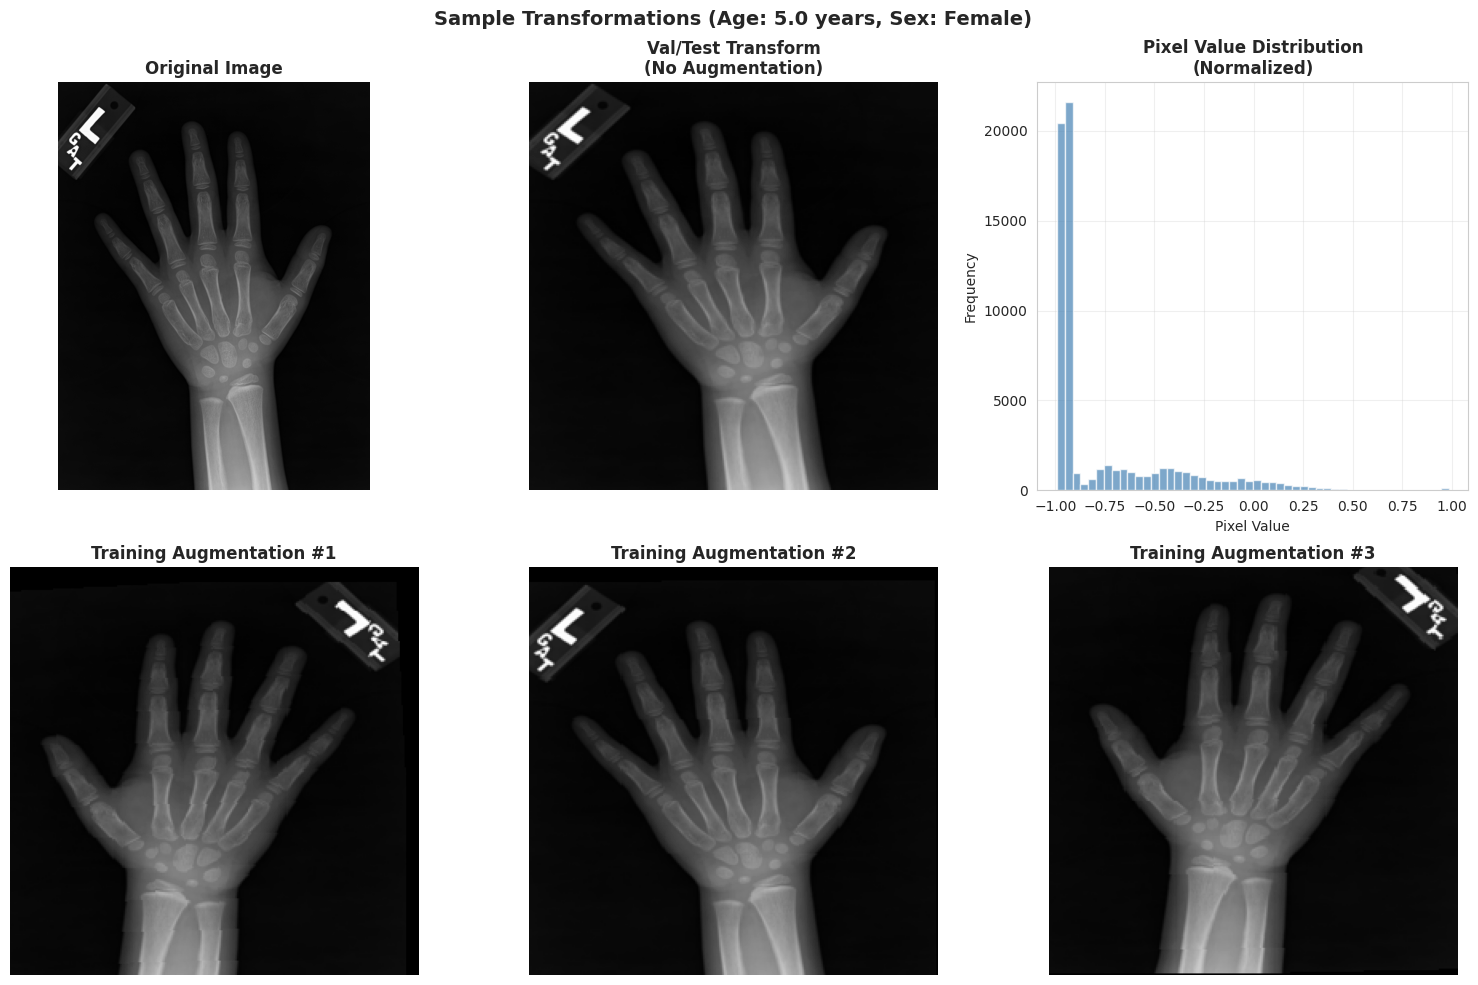

✓ Visualization complete!


In [65]:
print("\n[STEP 4] Creating Dataset Instances...")
print("-" * 80)

# Create dataset instances
train_dataset = BoneAgeDataset(train_df, transform=train_transforms)
val_dataset = BoneAgeDataset(val_df, transform=val_test_transforms)
test_dataset = BoneAgeDataset(test_df, transform=val_test_transforms)

print("✓ Dataset instances created:")
print(f"  train_dataset: {len(train_dataset):,} samples (with augmentation)")
print(f"  val_dataset:   {len(val_dataset):,} samples (no augmentation)")
print(f"  test_dataset:  {len(test_dataset):,} samples (no augmentation)")

# Display dataset statistics
print("\n📊 Dataset Statistics:")
for name, dataset in [('Train', train_dataset), ('Val', val_dataset), ('Test', test_dataset)]:
    stats = dataset.get_stats()
    print(f"\n  {name}:")
    print(f"    Samples: {stats['size']:,}")
    print(f"    Age - Mean: {stats['mean_age']:.2f}, Std: {stats['std_age']:.2f}, "
          f"Range: [{stats['min_age']:.2f}, {stats['max_age']:.2f}]")
    print(f"    Sex - Female: {stats['sex_distribution'].get(0, 0):,}, "
          f"Male: {stats['sex_distribution'].get(1, 0):,}")


# ============================================================================
# 5. TEST DATASET FUNCTIONALITY
# ============================================================================

print("\n[STEP 5] Testing Dataset Functionality...")
print("-" * 80)

# Test loading a single sample
try:
    test_img, test_age, test_sex = train_dataset[0]
    print("✓ Successfully loaded sample from dataset")
    print(f"  Image shape: {test_img.shape}")
    print(f"  Image dtype: {test_img.dtype}")
    print(f"  Image range: [{test_img.min():.3f}, {test_img.max():.3f}]")
    print(f"  Bone age: {test_age.item():.2f} years")
    print(f"  Sex encoded: {test_sex.item():.0f}")
except Exception as e:
    print(f"✗ Error loading sample: {str(e)}")

# Visualize a sample with augmentation comparison
print("\n[STEP 6] Visualizing Sample Transformations...")
print("-" * 80)

# Get a sample from the training dataframe
sample_idx = 0
sample_path = train_df.iloc[sample_idx]['path']
sample_age = train_df.iloc[sample_idx]['bone_age_years']
sample_sex = 'Male' if train_df.iloc[sample_idx]['sex_encoded'] == 1 else 'Female'

# Load original image
original_img = Image.open(sample_path).convert('RGB')

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Sample Transformations (Age: {sample_age:.1f} years, Sex: {sample_sex})', 
             fontsize=14, fontweight='bold')

# Original image
axes[0, 0].imshow(original_img, cmap='gray')
axes[0, 0].set_title('Original Image', fontweight='bold')
axes[0, 0].axis('off')

# Validation transform (no augmentation)
val_transformed = val_test_transforms(original_img)
val_img_display = val_transformed.squeeze().numpy()
axes[0, 1].imshow(val_img_display, cmap='gray')
axes[0, 1].set_title('Val/Test Transform\n(No Augmentation)', fontweight='bold')
axes[0, 1].axis('off')

# Show pixel value range
axes[0, 2].hist(val_img_display.flatten(), bins=50, color='steelblue', alpha=0.7)
axes[0, 2].set_title('Pixel Value Distribution\n(Normalized)', fontweight='bold')
axes[0, 2].set_xlabel('Pixel Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# Three augmented versions
for i in range(3):
    aug_img = train_transforms(original_img)
    aug_display = aug_img.squeeze().numpy()
    axes[1, i].imshow(aug_display, cmap='gray')
    axes[1, i].set_title(f'Training Augmentation #{i+1}', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

In [66]:
print("\n" + "=" * 80)
print("DATA PREPARATION PIPELINE COMPLETE")
print("=" * 80)

print("\n✅ Summary of Created Objects:")
print(f"  1. DataFrames:")
print(f"     - train_df: {len(train_df):,} samples (70%)")
print(f"     - val_df:   {len(val_df):,} samples (15%)")
print(f"     - test_df:  {len(test_df):,} samples (15%)")

print(f"\n  2. Transform Pipelines:")
print(f"     - train_transforms: 7-step pipeline with augmentation")
print(f"     - val_test_transforms: 4-step pipeline without augmentation")

print(f"\n  3. Dataset Instances:")
print(f"     - train_dataset: BoneAgeDataset({len(train_dataset):,} samples)")
print(f"     - val_dataset:   BoneAgeDataset({len(val_dataset):,} samples)")
print(f"     - test_dataset:  BoneAgeDataset({len(test_dataset):,} samples)")

print("\n" + "=" * 80)


DATA PREPARATION PIPELINE COMPLETE

✅ Summary of Created Objects:
  1. DataFrames:
     - train_df: 8,827 samples (70%)
     - val_df:   1,892 samples (15%)
     - test_df:  1,892 samples (15%)

  2. Transform Pipelines:
     - train_transforms: 7-step pipeline with augmentation
     - val_test_transforms: 4-step pipeline without augmentation

  3. Dataset Instances:
     - train_dataset: BoneAgeDataset(8,827 samples)
     - val_dataset:   BoneAgeDataset(1,892 samples)
     - test_dataset:  BoneAgeDataset(1,892 samples)



## HYBRID METHOD

In [67]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm
import time

print("=" * 80)
print("HYBRID CNN-CLASSICAL ML FEATURE EXTRACTION PIPELINE")
print("=" * 80)

HYBRID CNN-CLASSICAL ML FEATURE EXTRACTION PIPELINE


In [68]:
import os

print(os.listdir("/kaggle/input"))


['resnet50-pretrained-weights', 'rsna-bone-age']


In [69]:
print(os.listdir("/kaggle/input/rsna-bone-age"))


['boneage-training-dataset.csv', 'boneage-training-dataset', 'boneage-test-dataset', 'boneage-test-dataset.csv']


In [70]:
import os
print(os.listdir("/kaggle/input/resnet50-pretrained-weights"))


['resnet50-11ad3fa6.pth']


In [71]:
print("\n[STEP 1] Defining CNN Feature Extractor...")
print("-" * 80)

class FeatureExtractor(nn.Module):
    """
    Frozen ResNet-50 feature extractor adapted for greyscale medical images.
    
    Extracts 2048-dimensional feature vectors from the final convolutional block
    (after global average pooling) to be used with classical ML models.
    
    Architecture:
        - Input: Greyscale image (1 channel, 256x256)
        - Backbone: ResNet-50 pretrained on ImageNet
        - Output: 2048-dimensional feature vector
        - All weights frozen (requires_grad=False)
    """
    
    def __init__(self, weights_path=None):
        """
        Initialize the feature extractor with frozen ResNet-50.
        
        Args:
            weights_path (str, optional): Path to local .pth weights file.
                If None, will try to use torchvision's default weights.
                Example: '/kaggle/input/resnet50-weights/resnet50-11ad3fa6.pth'
        """
        super(FeatureExtractor, self).__init__()
        
        # Load pretrained ResNet-50
        if weights_path is not None:
            print(f"  Loading ResNet-50 from local weights: {weights_path}")
            # Create model without pretrained weights first
            self.resnet = models.resnet50(weights=None)
            # Load weights from local file
            state_dict = torch.load(weights_path, map_location='cpu')
            self.resnet.load_state_dict(state_dict)
            print("  ✓ Local weights loaded successfully")
        else:
            print("  Loading ResNet-50 with IMAGENET1K_V2 weights...")
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Adapt first convolutional layer for single-channel (greyscale) input
        # Original: Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        # Modified: Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        print("  Adapting input layer for greyscale (1-channel) images...")
        
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,  # Change from 3 (RGB) to 1 (greyscale)
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )
        
        # Initialize new conv1 layer by averaging the original RGB weights
        # This preserves the learned features from ImageNet pretraining
        with torch.no_grad():
            self.resnet.conv1.weight = nn.Parameter(
                original_conv1.weight.mean(dim=1, keepdim=True)
            )
        
        # Remove the final fully connected layer (we want features, not classifications)
        # ResNet-50 outputs 2048 features after avgpool, before fc layer
        print("  Removing final classification layer (keeping 2048-dim features)...")
        self.resnet.fc = nn.Identity()  # Replace fc with identity (pass-through)
        
        # Freeze all parameters - critical for efficiency and stability
        print("  Freezing all ResNet-50 parameters...")
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Verify parameter freezing
        total_params = sum(p.numel() for p in self.resnet.parameters())
        frozen_params = sum(p.numel() for p in self.resnet.parameters() if not p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Frozen parameters: {frozen_params:,}")
        assert total_params == frozen_params, "Not all parameters are frozen!"
        
    def forward(self, x):
        """
        Extract features from input images.
        
        Args:
            x: Input tensor of shape (batch_size, 1, 256, 256)
            
        Returns:
            features: Feature tensor of shape (batch_size, 2048)
        """
        # Pass through ResNet (will output 2048-dim features after avgpool)
        features = self.resnet(x)
        return features


# Instantiate the feature extractor
# CONFIGURE YOUR WEIGHTS PATH HERE
# Option 1: Use local weights file (recommended for Kaggle)
WEIGHTS_PATH = "/kaggle/input/resnet50-pretrained-weights/resnet50-11ad3fa6.pth"

# Option 2: Download from internet (comment out line above, uncomment below)
# WEIGHTS_PATH = None

# Check if weights file exists
import os
if WEIGHTS_PATH is not None:
    if os.path.exists(WEIGHTS_PATH):
        print(f"✓ Found weights file: {WEIGHTS_PATH}")
        feature_extractor = FeatureExtractor(weights_path=WEIGHTS_PATH)
    else:
        print(f"⚠ WARNING: Weights file not found at {WEIGHTS_PATH}")
        print("  Please verify the path or upload the weights file to Kaggle")
        print("  Expected format: /kaggle/input/<dataset-name>/<filename>.pth")
        print("\n  Attempting to download weights from internet instead...")
        feature_extractor = FeatureExtractor(weights_path=None)
else:
    print("Using online weights (will download from internet)")
    feature_extractor = FeatureExtractor(weights_path=None)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Feature extractor created successfully!")
print(f"  Device: {device}")
print(f"  Output feature dimension: 2048")

# Move model to device and set to evaluation mode
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode (disables dropout, etc.)

print("  Model moved to device and set to evaluation mode")


[STEP 1] Defining CNN Feature Extractor...
--------------------------------------------------------------------------------
✓ Found weights file: /kaggle/input/resnet50-pretrained-weights/resnet50-11ad3fa6.pth
  Loading ResNet-50 from local weights: /kaggle/input/resnet50-pretrained-weights/resnet50-11ad3fa6.pth
  ✓ Local weights loaded successfully
  Adapting input layer for greyscale (1-channel) images...
  Removing final classification layer (keeping 2048-dim features)...
  Freezing all ResNet-50 parameters...
  Total parameters: 23,501,760
  Frozen parameters: 23,501,760

✓ Feature extractor created successfully!
  Device: cuda
  Output feature dimension: 2048
  Model moved to device and set to evaluation mode


In [72]:
print("\n[STEP 2] Defining Feature Extraction Function...")
print("-" * 80)

def extract_features(dataloader, model, device):
    """
    Extract features from all images in a DataLoader using a frozen CNN.
    
    Args:
        dataloader: PyTorch DataLoader containing image batches
        model: Feature extraction model (frozen CNN)
        device: torch.device (CPU or CUDA)
        
    Returns:
        features_array: NumPy array of shape (num_samples, 2048) containing extracted features
        
    Note:
        - Runs in evaluation mode with no gradient computation
        - Displays progress bar for user feedback
        - Returns features on CPU as NumPy array for scikit-learn compatibility
    """
    model.eval()  # Ensure evaluation mode
    features_list = []
    
    print(f"  Extracting features from {len(dataloader.dataset):,} images...")
    print(f"  Number of batches: {len(dataloader)}")
    
    # Disable gradient computation for efficiency
    with torch.no_grad():
        # Use tqdm for progress bar
        for batch_idx, (images, _, _) in enumerate(tqdm(dataloader, desc="  Progress")):
            # Move images to device
            images = images.to(device)
            
            # Extract features
            batch_features = model(images)
            
            # Move to CPU and convert to numpy
            batch_features = batch_features.cpu().numpy()
            
            # Append to list
            features_list.append(batch_features)
    
    # Concatenate all batches into single array
    features_array = np.vstack(features_list)
    
    print(f"  ✓ Extraction complete! Shape: {features_array.shape}")
    
    return features_array


print("✓ Feature extraction function defined")


[STEP 2] Defining Feature Extraction Function...
--------------------------------------------------------------------------------
✓ Feature extraction function defined


In [73]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        
        # --- FIX 1: Use the scaled target (bone age in years) ---
        age = row["bone_age_years"] 
        
        gender = row["sex_encoded"]

        # Load as greyscale
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        # --- FIX 2: Return correct tensor types/order ---
        # The training loop expects: (images, ages, sexes)
        age_tensor = torch.tensor([age], dtype=torch.float32)
        sex_tensor = torch.tensor([gender], dtype=torch.float32)

        return img, age_tensor, sex_tensor

In [74]:
print("\n[STEP 3] Creating DataLoaders and Extracting Features...")
print("-" * 80)

# Configuration
BATCH_SIZE = 128
NUM_WORKERS = 2  # Number of subprocesses for data loading

print(f"DataLoader configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of workers: {NUM_WORKERS}")
print(f"  Transforms: val_test_transforms (no augmentation)")

# Create DataLoader instances
print("\n📦 Creating DataLoaders...")

train_loader = DataLoader(
    BoneAgeDataset(train_df, transform=val_test_transforms),
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle for feature extraction
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    BoneAgeDataset(val_df, transform=val_test_transforms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    BoneAgeDataset(test_df, transform=val_test_transforms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✓ DataLoaders created:")
print(f"  train_loader: {len(train_loader.dataset):,} samples, {len(train_loader)} batches")
print(f"  val_loader:   {len(val_loader.dataset):,} samples, {len(val_loader)} batches")
print(f"  test_loader:  {len(test_loader.dataset):,} samples, {len(test_loader)} batches")

# Extract features for all datasets
print("\n🔍 Extracting CNN features...")
print("=" * 80)

start_time = time.time()

print("\n[A] Training Set Features:")
X_train_cnn = extract_features(train_loader, feature_extractor, device)

print("\n[B] Validation Set Features:")
X_val_cnn = extract_features(val_loader, feature_extractor, device)

print("\n[C] Test Set Features:")
X_test_cnn = extract_features(test_loader, feature_extractor, device)

extraction_time = time.time() - start_time

print("\n" + "=" * 80)
print(f"✓ Feature extraction completed in {extraction_time:.2f} seconds")
print(f"  Average time per image: {extraction_time / (len(train_df) + len(val_df) + len(test_df)) * 1000:.2f} ms")



[STEP 3] Creating DataLoaders and Extracting Features...
--------------------------------------------------------------------------------
DataLoader configuration:
  Batch size: 128
  Number of workers: 2
  Transforms: val_test_transforms (no augmentation)

📦 Creating DataLoaders...
✓ DataLoaders created:
  train_loader: 8,827 samples, 69 batches
  val_loader:   1,892 samples, 15 batches
  test_loader:  1,892 samples, 15 batches

🔍 Extracting CNN features...

[A] Training Set Features:
  Extracting features from 8,827 images...
  Number of batches: 69


  Progress:   0%|          | 0/69 [00:00<?, ?it/s]

  ✓ Extraction complete! Shape: (8827, 2048)

[B] Validation Set Features:
  Extracting features from 1,892 images...
  Number of batches: 15


  Progress:   0%|          | 0/15 [00:00<?, ?it/s]

  ✓ Extraction complete! Shape: (1892, 2048)

[C] Test Set Features:
  Extracting features from 1,892 images...
  Number of batches: 15


  Progress:   0%|          | 0/15 [00:00<?, ?it/s]

  ✓ Extraction complete! Shape: (1892, 2048)

✓ Feature extraction completed in 270.24 seconds
  Average time per image: 21.43 ms


In [75]:
print("\n[STEP 4] Preparing Final Feature Matrices for scikit-learn...")
print("-" * 80)

# Extract sex_encoded feature from DataFrames
sex_train = train_df['sex_encoded'].values.reshape(-1, 1)
sex_val = val_df['sex_encoded'].values.reshape(-1, 1)
sex_test = test_df['sex_encoded'].values.reshape(-1, 1)

print("Sex feature shapes:")
print(f"  sex_train: {sex_train.shape}")
print(f"  sex_val:   {sex_val.shape}")
print(f"  sex_test:  {sex_test.shape}")

# Concatenate CNN features with sex_encoded feature
X_train = np.hstack([X_train_cnn, sex_train])
X_val = np.hstack([X_val_cnn, sex_val])
X_test = np.hstack([X_test_cnn, sex_test])

print("\n✓ Final feature matrices created:")
print(f"  X_train: {X_train.shape} (2048 CNN features + 1 sex feature = 2049 total)")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Extract target variables (bone age in years)
y_train = train_df['bone_age_years'].values
y_val = val_df['bone_age_years'].values
y_test = test_df['bone_age_years'].values

print("\n✓ Target variables extracted:")
print(f"  y_train: {y_train.shape} - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  y_val:   {y_val.shape} - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"  y_test:  {y_test.shape} - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Verify data consistency
assert X_train.shape[0] == y_train.shape[0], "Mismatch in training set size"
assert X_val.shape[0] == y_val.shape[0], "Mismatch in validation set size"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in test set size"
assert X_train.shape[1] == 2049, "Expected 2049 features (2048 CNN + 1 sex)"

print("\n✓ Data consistency verified!")



[STEP 4] Preparing Final Feature Matrices for scikit-learn...
--------------------------------------------------------------------------------
Sex feature shapes:
  sex_train: (8827, 1)
  sex_val:   (1892, 1)
  sex_test:  (1892, 1)

✓ Final feature matrices created:
  X_train: (8827, 2049) (2048 CNN features + 1 sex feature = 2049 total)
  X_val:   (1892, 2049)
  X_test:  (1892, 2049)

✓ Target variables extracted:
  y_train: (8827,) - Mean: 10.59, Std: 3.41
  y_val:   (1892,) - Mean: 10.52, Std: 3.60
  y_test:  (1892,) - Mean: 10.78, Std: 3.35

✓ Data consistency verified!


## RANDOM FOREST REGRESSOR

In [76]:
print("\n[STEP 5] Training Random Forest Regressor (Baseline Model)...")
print("-" * 80)

# Instantiate Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,  # Use all available CPU cores
    verbose=1    # Show progress
)

print("Random Forest configuration:")
print(f"  n_estimators: 100")
print(f"  random_state: 42")
print(f"  n_jobs: -1 (all CPU cores)")

# Train the model
print("\n🌲 Training Random Forest on combined features...")
start_train_time = time.time()

rf_regressor.fit(X_train, y_train)

train_time = time.time() - start_train_time
print(f"✓ Training completed in {train_time:.2f} seconds")

# Make predictions on all sets
print("\n📊 Making predictions...")
y_train_pred = rf_regressor.predict(X_train)
y_val_pred = rf_regressor.predict(X_val)
y_test_pred = rf_regressor.predict(X_test)

# Calculate metrics
print("\n" + "=" * 80)
print("REGRESSION PERFORMANCE EVALUATION")
print("=" * 80)

def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and display regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Performance:")
    print(f"  Mean Absolute Error (MAE):  {mae:.4f} years")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f} years")
    print(f"  R² Score: {r2:.4f}")
    
    return mae, rmse, r2

# Calculate metrics for all sets
train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred, "Training")
val_mae, val_rmse, val_r2 = calculate_metrics(y_val, y_val_pred, "Validation")
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred, "Test")

# Feature importance analysis
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

feature_importance = rf_regressor.feature_importances_
cnn_importance = feature_importance[:-1].sum()  # Sum of all CNN features
sex_importance = feature_importance[-1]  # Last feature is sex_encoded

print(f"\nFeature group contributions:")
print(f"  CNN Features (2048 features): {cnn_importance:.4f} ({cnn_importance*100:.2f}%)")
print(f"  Sex Feature (1 feature):      {sex_importance:.4f} ({sex_importance*100:.2f}%)")

# Top 10 most important CNN features
top_indices = np.argsort(feature_importance[:-1])[-10:][::-1]
print(f"\n🏆 Top 10 most important CNN features:")
for i, idx in enumerate(top_indices, 1):
    print(f"  {i}. Feature {idx}: {feature_importance[idx]:.6f}")


[STEP 5] Training Random Forest Regressor (Baseline Model)...
--------------------------------------------------------------------------------
Random Forest configuration:
  n_estimators: 100
  random_state: 42
  n_jobs: -1 (all CPU cores)

🌲 Training Random Forest on combined features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


✓ Training completed in 334.96 seconds

📊 Making predictions...

REGRESSION PERFORMANCE EVALUATION

Training Set Performance:
  Mean Absolute Error (MAE):  0.5011 years
  Root Mean Squared Error (RMSE): 0.6616 years
  R² Score: 0.9624

Validation Set Performance:
  Mean Absolute Error (MAE):  1.4138 years
  Root Mean Squared Error (RMSE): 1.8856 years
  R² Score: 0.7256

Test Set Performance:
  Mean Absolute Error (MAE):  1.3647 years
  Root Mean Squared Error (RMSE): 1.7996 years
  R² Score: 0.7109

FEATURE IMPORTANCE ANALYSIS

Feature group contributions:
  CNN Features (2048 features): 0.9524 (95.24%)
  Sex Feature (1 feature):      0.0476 (4.76%)

🏆 Top 10 most important CNN features:
  1. Feature 1368: 0.203974
  2. Feature 1814: 0.088511
  3. Feature 1526: 0.062121
  4. Feature 749: 0.029646
  5. Feature 1382: 0.024186
  6. Feature 1420: 0.014740
  7. Feature 812: 0.013610
  8. Feature 885: 0.013088
  9. Feature 1851: 0.012588
  10. Feature 1950: 0.011343


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


## SUPPORT VECTOR REGRESSOR

In [77]:
print("\n" + "=" * 80)
print("2. Support Vector Regressor (SVR) - Linear Kernel")
print("=" * 80)


2. Support Vector Regressor (SVR) - Linear Kernel


In [78]:
import time
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# --- Utility Function: Calculate Metrics ---
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and display regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{set_name} Set Performance:")
    print(f"  Mean Absolute Error (MAE):  {mae:.4f} years")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f} years")
    print(f"  R² Score: {r2:.4f}")

    return mae, rmse, r2

In [79]:
svr_regressor = SVR(kernel='linear', C=1.0, epsilon=0.1)
print("\n🚀 Training SVR on combined features...")
start_train_time = time.time()
svr_regressor.fit(X_train, y_train)
train_time = time.time() - start_train_time
print(f"✓ Training completed in {train_time:.2f} seconds")
y_train_pred_svr = svr_regressor.predict(X_train)
y_val_pred_svr = svr_regressor.predict(X_val)
y_test_pred_svr = svr_regressor.predict(X_test)
print("\n📊 SVR Performance (Test Set):")
calculate_metrics(y_test, y_test_pred_svr, "Test")


🚀 Training SVR on combined features...
✓ Training completed in 129.68 seconds

📊 SVR Performance (Test Set):

Test Set Performance:
  Mean Absolute Error (MAE):  1.0958 years
  Root Mean Squared Error (RMSE): 1.4246 years
  R² Score: 0.8188


(1.0957731598450935, 1.4246302348113322, 0.8188256237745022)

In [80]:
calculate_metrics(y_train, y_train_pred_svr, "Train") # ADDED
calculate_metrics(y_val, y_val_pred_svr, "Validation") # ADDED


Train Set Performance:
  Mean Absolute Error (MAE):  0.8432 years
  Root Mean Squared Error (RMSE): 1.1826 years
  R² Score: 0.8798

Validation Set Performance:
  Mean Absolute Error (MAE):  1.1392 years
  Root Mean Squared Error (RMSE): 1.5081 years
  R² Score: 0.8245


(1.1392049413307908, 1.5081214503869171, 0.8244862220494105)

## RIDGE REGRESSION

In [81]:
print("\n" + "=" * 80)
print("3. Ridge Regression")
print("=" * 80)


3. Ridge Regression


In [82]:
ridge_regressor = Ridge(alpha=1.0, random_state=42, solver='auto')
start_train_time = time.time()
ridge_regressor.fit(X_train, y_train)
y_train_pred_ridge = ridge_regressor.predict(X_train)
y_val_pred_ridge = ridge_regressor.predict(X_val)
y_test_pred_ridge = ridge_regressor.predict(X_test)
print(f"✓ Training completed in {time.time() - start_train_time:.2f} seconds")

print("\n📊 Ridge Performance (Test Set):")
calculate_metrics(y_test, y_test_pred_ridge, "Test")

✓ Training completed in 0.63 seconds

📊 Ridge Performance (Test Set):

Test Set Performance:
  Mean Absolute Error (MAE):  1.0767 years
  Root Mean Squared Error (RMSE): 1.4003 years
  R² Score: 0.8250


(1.0766761729574534, 1.4003152912707055, 0.824957251843877)

In [83]:
calculate_metrics(y_train, y_train_pred_ridge, "Train") # ADDED
calculate_metrics(y_val, y_val_pred_ridge, "Validation") # ADDED


Train Set Performance:
  Mean Absolute Error (MAE):  0.8780 years
  Root Mean Squared Error (RMSE): 1.1212 years
  R² Score: 0.8920

Validation Set Performance:
  Mean Absolute Error (MAE):  1.1280 years
  Root Mean Squared Error (RMSE): 1.4854 years
  R² Score: 0.8297


(1.1280388575913451, 1.4853717815337473, 0.8297414546184021)

## HISTGRADIENT BOOSTING

In [84]:
print("\n" + "=" * 80)
print("1. HistGradientBoosting Regressor")
print("=" * 80)


1. HistGradientBoosting Regressor


In [85]:
hgb_regressor = HistGradientBoostingRegressor(random_state=42, verbose=0, max_iter=100)
start_train_time = time.time()
hgb_regressor.fit(X_train, y_train)
y_train_pred_hgb = hgb_regressor.predict(X_train)
y_val_pred_hgb = hgb_regressor.predict(X_val)
y_test_pred_hgb = hgb_regressor.predict(X_test)
print(f"✓ Training completed in {time.time() - start_train_time:.2f} seconds")

print("\n📊 HistGradientBoosting Performance (Test Set):")
calculate_metrics(y_train, y_train_pred_hgb, "Train") 
calculate_metrics(y_val, y_val_pred_hgb, "Validation") 
calculate_metrics(y_test, y_test_pred_hgb, "Test")

✓ Training completed in 26.88 seconds

📊 HistGradientBoosting Performance (Test Set):

Train Set Performance:
  Mean Absolute Error (MAE):  0.6235 years
  Root Mean Squared Error (RMSE): 0.7872 years
  R² Score: 0.9468

Validation Set Performance:
  Mean Absolute Error (MAE):  1.1878 years
  Root Mean Squared Error (RMSE): 1.5961 years
  R² Score: 0.8034

Test Set Performance:
  Mean Absolute Error (MAE):  1.1813 years
  Root Mean Squared Error (RMSE): 1.5404 years
  R² Score: 0.7882


(1.1812803038350055, 1.5404237379764216, 0.7881771214656068)

## XGBOOST REGRESSOR

In [86]:
from xgboost import XGBRegressor

In [87]:
print("=" * 80)
print("XGBoost Regressor")
print("=" * 80)

XGBoost Regressor


In [88]:
xgb_regressor = XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbosity=0 # Suppress console output during training
)

print("XGBoost configuration:")
print(f"  n_estimators: 100 (Matches RF)")
print(f"  random_state: 42")

print("\n🚀 Training XGBoost on combined features...")
start_train_time = time.time()
xgb_regressor.fit(X_train, y_train)
train_time = time.time() - start_train_time
print(f"✓ Training completed in {train_time:.2f} seconds")

# Predictions
y_train_pred_xgb = xgb_regressor.predict(X_train)
y_val_pred_xgb = xgb_regressor.predict(X_val)
y_test_pred_xgb = xgb_regressor.predict(X_test)

print("\n📊 XGBoost Full Performance:")
# NOTE: The calculate_metrics function must be defined in your notebook
calculate_metrics(y_train, y_train_pred_xgb, "Train")
calculate_metrics(y_val, y_val_pred_xgb, "Validation")
calculate_metrics(y_test, y_test_pred_xgb, "Test")

XGBoost configuration:
  n_estimators: 100 (Matches RF)
  random_state: 42

🚀 Training XGBoost on combined features...
✓ Training completed in 46.05 seconds

📊 XGBoost Full Performance:

Train Set Performance:
  Mean Absolute Error (MAE):  0.1348 years
  Root Mean Squared Error (RMSE): 0.1757 years
  R² Score: 0.9973

Validation Set Performance:
  Mean Absolute Error (MAE):  1.3083 years
  Root Mean Squared Error (RMSE): 1.7314 years
  R² Score: 0.7687

Test Set Performance:
  Mean Absolute Error (MAE):  1.3029 years
  Root Mean Squared Error (RMSE): 1.7174 years
  R² Score: 0.7367


(1.302925883642043, 1.7174188724211275, 0.7367035991741653)

## STACKING REGRESSOR - ENSEMBLE 

In [89]:
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from xgboost import XGBRegressor # Ensure this is available

# NOTE: Assuming X_train, y_train, X_val, y_val, X_test, y_test are defined, 
# and individual regressors (svr_regressor, ridge_regressor, etc.) are defined.

# Re-define the individual regressors with their configurations (for clean stacking)
svr_regressor = SVR(kernel='linear', C=1.0, epsilon=0.1)
ridge_regressor = Ridge(alpha=1.0, random_state=42, solver='auto')
hgb_regressor = HistGradientBoostingRegressor(max_iter=100, random_state=42, verbose=0)
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)


# --- 1. Define Base Estimators ---
estimators = [
    ('ridge', ridge_regressor),      # Best performer, Linear
    ('svr', svr_regressor),          # Second best, Kernel-based
    ('hgb', hgb_regressor),          # Best Tree-based model
    ('xgb', xgb_regressor),          # High complexity boosting
]

# --- 2. Define Stacking Regressor ---
print("=" * 80)
print("STACKING REGRESSOR SETUP (Final Ensemble)")
print("=" * 80)

stacked_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(), # Optimal Meta-Model: RidgeCV
    cv=5,                      # 5-fold CV for robust meta-model training
    n_jobs=-1,            
    passthrough=True           # Pass original features to the Meta-Model
)

print("\n🚀 Training Stacking Regressor...")
start_train_time = time.time()
stacked_regressor.fit(X_train, y_train)
train_time = time.time() - start_train_time
print(f"✓ Training completed in {train_time:.2f} seconds")

# Predictions and Metrics
y_train_pred_stacked = stacked_regressor.predict(X_train)
y_val_pred_stacked = stacked_regressor.predict(X_val)
y_test_pred_stacked = stacked_regressor.predict(X_test)

print("\n📊 Stacking Regressor Full Performance:")
# NOTE: The calculate_metrics function must be defined in your notebook
calculate_metrics(y_train, y_train_pred_stacked, "Train")
calculate_metrics(y_val, y_val_pred_stacked, "Validation")
calculate_metrics(y_test, y_test_pred_stacked, "Test")

# You can now compare the Test MAE from the stacking model against the 1.0767 MAE of the Ridge model!

STACKING REGRESSOR SETUP (Final Ensemble)

🚀 Training Stacking Regressor...
✓ Training completed in 660.63 seconds

📊 Stacking Regressor Full Performance:

Train Set Performance:
  Mean Absolute Error (MAE):  0.8157 years
  Root Mean Squared Error (RMSE): 1.0715 years
  R² Score: 0.9014

Validation Set Performance:
  Mean Absolute Error (MAE):  1.1389 years
  Root Mean Squared Error (RMSE): 1.4994 years
  R² Score: 0.8265

Test Set Performance:
  Mean Absolute Error (MAE):  1.0908 years
  Root Mean Squared Error (RMSE): 1.4105 years
  R² Score: 0.8224


(1.090838304076026, 1.4104819297593585, 0.8224063170530066)

In [90]:
import pandas as pd
import numpy as np

# --- Final Test Metrics Data ---
data = {
    'Model': ['Random Forest (RF)', 'SVR', 'Ridge', 'HistGB', 'XGBoost', 'Stacking Regressor'],
    'Test MAE (Years)': [1.3647, 1.0958, 1.0767, 1.1813, 1.3029, 1.0908],
    'Test RMSE (Years)': [1.7996, 1.4246, 1.4003, 1.5404, 1.7174, 1.4105],
    'Test R² Score': [0.7109, 0.8188, 0.8250, 0.7882, 0.7367, 0.8224]
}
df_comparison = pd.DataFrame(data)

# Sort by MAE (best performing first)
df_final_ranking = df_comparison.sort_values(by='Test MAE (Years)', ascending=True).reset_index(drop=True)

# --- Display Final Ranking Table ---
print("=" * 80)
print("FINAL COMPREHENSIVE TEST SET RANKING")
print("=" * 80)

# Use to_markdown for clear tabular output
print(df_final_ranking.to_markdown(index=False, floatfmt=".4f"))

FINAL COMPREHENSIVE TEST SET RANKING
| Model              |   Test MAE (Years) |   Test RMSE (Years) |   Test R² Score |
|:-------------------|-------------------:|--------------------:|----------------:|
| Ridge              |             1.0767 |              1.4003 |          0.8250 |
| Stacking Regressor |             1.0908 |              1.4105 |          0.8224 |
| SVR                |             1.0958 |              1.4246 |          0.8188 |
| HistGB             |             1.1813 |              1.5404 |          0.7882 |
| XGBoost            |             1.3029 |              1.7174 |          0.7367 |
| Random Forest (RF) |             1.3647 |              1.7996 |          0.7109 |


## END TO END CNN

In [91]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import mean_absolute_error
import time
import os

In [92]:
RANDOM_STATE = 42
IMG_SIZE = 256
BATCH_SIZE = 128
NUM_WORKERS = 2
WEIGHTS_PATH = "/kaggle/input/resnet50-pretrained-weights/resnet50-11ad3fa6.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [93]:
class BoneAgeCNN(nn.Module):
    """
    End-to-end CNN Model for Bone Age Regression.
    
    Uses a pre-trained ResNet-50 backbone, adapting it for 1-channel input 
    and concatenating the sex_encoded feature before the final regression layer.
    """
    def __init__(self, weights_path=None):
        super(BoneAgeCNN, self).__init__()
        
        # Load pre-trained ResNet-50
        print("  Loading ResNet-50 backbone...")
        self.resnet = models.resnet50(weights=None)
        
        if weights_path and os.path.exists(weights_path):
            print(f"  Loading local weights from: {weights_path}")
            state_dict = torch.load(weights_path, map_location='cpu')
            self.resnet.load_state_dict(state_dict)
            print("  ✓ Local weights loaded successfully")
        else:
            print("  Loading IMAGENET1K_V2 weights (will download if not cached)...")
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # 1. Adapt first convolutional layer for 1-channel (grayscale) input
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )
        # Initialize new conv1 weights by averaging original RGB weights
        with torch.no_grad():
            self.resnet.conv1.weight = nn.Parameter(
                original_conv1.weight.mean(dim=1, keepdim=True)
            )

        # 2. Extract features up to the last pooling layer
        # The output from the last pooling layer (avgpool) is 2048-dim
        self.features = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,
            self.resnet.avgpool,
            nn.Flatten() # Flatten the (B, 2048, 1, 1) tensor to (B, 2048)
        )
        
        # 3. Custom Regression Head (2048 CNN features + 1 sex feature = 2049)
        # Final fully connected layer outputs a single bone age value
        self.regression_head = nn.Sequential(
            nn.Dropout(0.5), # Add dropout for regularization
            nn.Linear(2048 + 1, 1) 
        )
        
    def forward(self, image, sex_encoded):
        # 1. Extract CNN features
        cnn_features = self.features(image)
        
        # 2. Concatenate CNN features with sex_encoded feature
        # cnn_features: (B, 2048), sex_encoded: (B, 1) -> combined: (B, 2049)
        combined_features = torch.cat((cnn_features, sex_encoded.view(-1, 1)), dim=1)
        
        # 3. Pass through the regression head
        prediction = self.regression_head(combined_features)
        
        return prediction

# Instantiate the model
cnn_model = BoneAgeCNN(weights_path=WEIGHTS_PATH)
cnn_model = cnn_model.to(device)

print(f"\n✅ BoneAgeCNN Model Initialized on {device}")

  Loading ResNet-50 backbone...
  Loading local weights from: /kaggle/input/resnet50-pretrained-weights/resnet50-11ad3fa6.pth
  ✓ Local weights loaded successfully

✅ BoneAgeCNN Model Initialized on cuda


In [94]:
train_loader = DataLoader(
    train_dataset, # Uses train_transforms (WITH augmentation)
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, # Uses val_test_transforms (NO augmentation)
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ DataLoaders for End-to-End Training configured.")
print(f"  Train Loader: {len(train_loader.dataset)} samples, Shuffle=True, With Augmentation.")

✅ DataLoaders for End-to-End Training configured.
  Train Loader: 8827 samples, Shuffle=True, With Augmentation.


In [95]:
# CODE CELL 3: Training Loop and Evaluation Function

# --- Loss Function and Optimizer ---
# MAE is a common metric and often a good choice for loss in bone age prediction
criterion = nn.L1Loss() # Mean Absolute Error (MAE)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4) # Start with a small learning rate

# --- Training Configuration ---
NUM_EPOCHS = 40 
# Note: For a pre-trained model and a dataset of this size, 10 epochs is a good
# starting point, but you might need more for convergence (e.g., 30-50).

print("=" * 80)
print(f"STARTING END-TO-END CNN TRAINING ({NUM_EPOCHS} Epochs)")
print("=" * 80)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, ages, sexes in dataloader:
        # Move data to device
        images, ages, sexes = images.to(device), ages.to(device), sexes.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, sexes)
        
        # Calculate loss (outputs and ages are [B, 1])
        loss = criterion(outputs, ages)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

@torch.no_grad() # No need to compute gradients during validation
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    for images, ages, sexes in dataloader:
        images, ages, sexes = images.to(device), ages.to(device), sexes.to(device)
        
        outputs = model(images, sexes)
        
        # Calculate loss
        loss = criterion(outputs, ages)
        running_loss += loss.item() * images.size(0)
        
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(ages.cpu().numpy().flatten())
        
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculate MAE in years
    mae = mean_absolute_error(all_targets, all_preds)
    
    return epoch_loss, mae

# --- Training Execution ---
best_val_mae = float('inf')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_mae = evaluate_model(cnn_model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss (MAE): {train_loss:.4f} | "
          f"Val Loss (MAE): {val_loss:.4f} | "
          f"Val MAE: {val_mae:.4f} years")
    
    # Simple checkpointing
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pth')
        print("  --> Model saved! Best MAE so far.")

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")
print("=" * 80)


# --- Final Test Evaluation ---
print("\nFINAL EVALUATION on Test Set...")
# Load best model weights
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))
test_loss, test_mae = evaluate_model(cnn_model, test_loader, criterion, device)

print(f"\n📊 Test Set Performance:")
print(f"  Test Loss (MAE): {test_loss:.4f}")
print(f"  Test Mean Absolute Error (MAE): {test_mae:.4f} years")
print("=" * 80)

STARTING END-TO-END CNN TRAINING (40 Epochs)
Epoch 1/40 - Train Loss (MAE): 3.6462 | Val Loss (MAE): 2.3268 | Val MAE: 2.3268 years
  --> Model saved! Best MAE so far.
Epoch 2/40 - Train Loss (MAE): 1.1358 | Val Loss (MAE): 1.1190 | Val MAE: 1.1190 years
  --> Model saved! Best MAE so far.
Epoch 3/40 - Train Loss (MAE): 1.0439 | Val Loss (MAE): 1.1552 | Val MAE: 1.1552 years
Epoch 4/40 - Train Loss (MAE): 1.0051 | Val Loss (MAE): 1.0746 | Val MAE: 1.0746 years
  --> Model saved! Best MAE so far.
Epoch 5/40 - Train Loss (MAE): 0.9598 | Val Loss (MAE): 0.8908 | Val MAE: 0.8908 years
  --> Model saved! Best MAE so far.
Epoch 6/40 - Train Loss (MAE): 0.9315 | Val Loss (MAE): 1.0700 | Val MAE: 1.0700 years
Epoch 7/40 - Train Loss (MAE): 0.9329 | Val Loss (MAE): 0.8909 | Val MAE: 0.8909 years
Epoch 8/40 - Train Loss (MAE): 0.9017 | Val Loss (MAE): 1.3536 | Val MAE: 1.3536 years
Epoch 9/40 - Train Loss (MAE): 0.8872 | Val Loss (MAE): 0.8857 | Val MAE: 0.8857 years
  --> Model saved! Best MAE 

In [96]:
# CODE CELL 5: Rerun Final Test Evaluation with Diagnostics

print("\n--- DIAGNOSTIC RE-EVALUATION on Test Set ---")
print("Attempting to load the best model checkpoint...")

# Ensure the model is on the correct device and in evaluation mode
cnn_model.to(device)
cnn_model.eval()

# Load best model weights (saved at Epoch 22 with Val MAE: 0.7359)
try:
    cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))
    print("✓ Model checkpoint loaded successfully!")
    
    # 1. Rerun evaluation
    test_loss, test_mae = evaluate_model(cnn_model, test_loader, criterion, device)

    # 2. Diagnostic Print (What the loaded model predicts)
    # Get a batch from the test loader
    for images, ages, sexes in test_loader:
        images, ages, sexes = images.to(device), ages.to(device), sexes.to(device)
        with torch.no_grad():
            preds = cnn_model(images, sexes).flatten().cpu().numpy()
            targets = ages.flatten().cpu().numpy()
        
        print("\n--- Prediction Samples (Years) ---")
        print(f"Target Ages (First 5): {targets[:5]}")
        print(f"Predicted Ages (First 5): {preds[:5]}")
        break # Only check the first batch

    print(f"\n📊 Test Set Performance (Corrected Run):")
    print(f"  Test Loss (MAE): {test_loss:.4f}")
    print(f"  Test Mean Absolute Error (MAE): {test_mae:.4f} years")
    print("=" * 80)

except Exception as e:
    print(f"❌ ERROR: Failed to load 'best_cnn_model.pth'. The file may be missing or corrupted.")
    print(f"Error details: {e}")
    print("Please check the training setup again.")


--- DIAGNOSTIC RE-EVALUATION on Test Set ---
Attempting to load the best model checkpoint...
✓ Model checkpoint loaded successfully!

--- Prediction Samples (Years) ---
Target Ages (First 5): [14.        10.         6.        13.         2.6666667]
Predicted Ages (First 5): [13.198373  10.146528   5.8119264 12.411792   2.6426344]

📊 Test Set Performance (Corrected Run):
  Test Loss (MAE): 0.7510
  Test Mean Absolute Error (MAE): 0.7510 years
